# 04 - Full waveform inversion with Devito and scipy.optimize.minimize

## Introduction

In this tutorial we show how [Devito](http://www.opesci.org/devito-public) can be used with [scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) to solve the FWI gradient based minimization problem described in the previous tutorial.

```python
scipy.optimize.minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
```

> Minimization of scalar function of one or more variables.
>
> In general, the optimization problems are of the form:
>
> minimize f(x) subject to
>
> g_i(x) >= 0,  i = 1,...,m
> h_j(x)  = 0,  j = 1,...,p
> where x is a vector of one or more variables. g_i(x) are the inequality constraints. h_j(x) are the equality constrains.

[scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) provides a wide variety of methods for solving minimization problems depending on the context. Here we are going to focus on using L-BFGS via [scipy.optimize.minimize(method=’L-BFGS-B’)](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html#optimize-minimize-lbfgsb)

```python
scipy.optimize.minimize(fun, x0, args=(), method='L-BFGS-B', jac=None, bounds=None, tol=None, callback=None, options={'disp': None, 'maxls': 20, 'iprint': -1, 'gtol': 1e-05, 'eps': 1e-08, 'maxiter': 15000, 'ftol': 2.220446049250313e-09, 'maxcor': 10, 'maxfun': 15000})```

The argument `fun` is a callable function that returns the misfit between the simulated and the observed data. If `jac` is a Boolean and is `True`, `fun` is assumed to return the gradient along with the objective function - as is our case when applying the adjoint-state method.

## Setting up (synthetic) data
We are going to set up the same synthetic test case as for the previous tutorial (refer back for details). The code below is slightly re-engineered to make it suitable for using with scipy.optimize.minimize.

In [1]:
#NBVAL_IGNORE_OUTPUT
from examples.seismic import Model, demo_model
import numpy as np

# Define the grid parameters
def get_grid():
    shape = (101, 101)    # Number of grid point (nx, nz)
    spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
    origin = (0., 0.)     # Need origin to define relative source and receiver locations

    return shape, spacing, origin

# Define the test phantom; in this case we are using a simple circle
# so we can easily see what is going on.
def get_true_model():
    shape, spacing, origin = get_grid()
    return demo_model('circle-isotropic', vp=3.0, vp_background=2.5, 
                      origin=origin, shape=shape, spacing=spacing, nbpml=40)

# The initial guess for the subsurface model.
def get_initial_model():
    shape, spacing, origin = get_grid()

    return demo_model('circle-isotropic', vp=2.5, vp_background=2.5, 
                      origin=origin, shape=shape, spacing=spacing, nbpml=40)

from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import RickerSource, Receiver

# Inversion crime alert! Here the worker is creating the 'observed' data
# using the real model. For a real case the worker would be reading
# seismic data from disk.
def get_data(param):
    """ Returns source and receiver data for a single shot labeled 'shot_id'.
    """
    true_model = get_true_model()
    dt = true_model.critical_dt  # Time step from model grid spacing

    # Set up source data and geometry.
    nt = int(1 + (param['tn']-param['t0']) / dt)  # Discrete time axis length

    src = RickerSource(name='src', grid=true_model.grid, f0=param['f0'],
                       time=np.linspace(param['t0'], param['tn'], nt))
    src.coordinates.data[0, :] = [30, param['shot_id']*1000./(param['nshots']-1)]

    # Set up receiver data and geometry.
    nreceivers = 101  # Number of receiver locations per shot
    rec = Receiver(name='rec', grid=true_model.grid, npoint=nreceivers, ntime=nt)
    rec.coordinates.data[:, 1] = np.linspace(0, true_model.domain_size[0], num=nreceivers)
    rec.coordinates.data[:, 0] = 980. # 20m from the right end

    # Set up solver - using model_in so that we have the same dt,
    # otherwise we should use pandas to resample the time series data. 
    solver = AcousticWaveSolver(true_model, src, rec, space_order=4)

    # Generate synthetic receiver data from true model
    true_d, _, _ = solver.forward(src=src, m=true_model.m)

    return src, true_d, nt, solver

## Create operators for gradient based inversion
To perform the inversion we are going to use [scipy.optimize.minimize(method=’L-BFGS-B’)](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html#optimize-minimize-lbfgsb).

First we define the functional, ```f```, and gradient, ```g```, operator (i.e. the function ```fun```) for a single shot of data.

In [2]:
from devito import Function, clear_cache

# Create FWI gradient kernel for a single shot
def fwi_gradient_i(x, param):
    # Need to clear the workers cache.
    clear_cache()

    # Get the current model and the shot data for this worker.
    model0 = get_initial_model()
    model0.m.data[:] = x.astype(np.float32).reshape(model0.m.data.shape)
    src, rec, nt, solver = get_data(param)
    
    # Create symbols to hold the gradient and the misfit between
    # the 'measured' and simulated data.
    grad = Function(name="grad", grid=model0.grid)
    residual = Receiver(name='rec', grid=model0.grid, ntime=nt, coordinates=rec.coordinates.data)
    
    # Compute simulated data and full forward wavefield u0
    d, u0, _ = solver.forward(src=src, m=model0.m, save=True)
        
    # Compute the data misfit (residual) and objective function  
    residual.data[:] = d.data[:] - rec.data[:]
    f = .5*np.linalg.norm(residual.data.flatten())**2
    
    # Compute gradient using the adjoint-state method. Note, this
    # backpropagates the data misfit through the model.
    solver.gradient(rec=residual, u=u0, m=model0.m, grad=grad)
    
    # return the objective functional and gradient.
    return f, np.array(grad.data)

Next we define the global functional and gradient function that sums the contributions to f and g for each shot of data.

In [3]:
def fwi_gradient(x, param):
    # Initialize f and g.
    param['shot_id'] = 0
    f, g = fwi_gradient_i(x, param)
    
    # Loop through all shots summing f, g.
    for i in  range(1, param['nshots']):
        param['shot_id'] = i
        f_i, g_i = fwi_gradient_i(x, param)
        f += f_i
        g[:] += g_i
    
    # Note the explicit cast; while the forward/adjoint solver only requires float32,
    # L-BFGS-B in SciPy expects a flat array in 64-bit floats.
    return f, g.flatten().astype(np.float64)

## FWI with L-BFGS-B
Equipped with a function to calculate the functional and gradient, we are finally ready to call ```scipy.optimize.minimize```.

In [4]:
#NBVAL_SKIP

# Change to the WARNING log level to reduce log output
# as compared to the default DEBUG
from devito import configuration
configuration['log_level'] = 'WARNING'

# Set up a dictionary of inversion parameters.
param = {'t0': 0.,
         'tn': 1000.,              # Simulation lasts 1 second (1000 ms)
         'f0': 0.010,              # Source peak frequency is 10Hz (0.010 kHz)
         'nshots': 9}              # Number of shots to create gradient from

# Define bounding box constraints on the solution.
def apply_box_constraint(m):
    # Maximum possible 'realistic' velocity is 3.5 km/sec
    # Minimum possible 'realistic' velocity is 2 km/sec
    return np.clip(m, 1/3.5**2, 1/2**2)

# Many optimization methods in scipy.optimize.minimize accept a callback
# function that can operate on the solution after every iteration. Here
# we use this to apply box constraints and to monitor the true relative
# solution error.
relative_error = []
def fwi_callbacks(x):
    # Apply boundary constraint
    x.data[:] = apply_box_constraint(x)
    
    # Calculate true relative error
    true_x = get_true_model().m.data.flatten()
    relative_error.append(np.linalg.norm((x-true_x)/true_x))

    
# Initialize solution
model0 = get_initial_model()

# Finally, calling the minimizing function. We are limiting the maximum number
# of iterations here to 10 so that it runs quickly for the purpose of the
# tutorial.
from scipy import optimize
result = optimize.minimize(fwi_gradient, model0.m.data.flatten().astype(np.float64),
                           args=(param, ), method='L-BFGS-B', jac=True,
                           callback=fwi_callbacks,
                           options={'maxiter':10, 'disp':True})

# Print out results of optimizer.
print(result)

      fun: 45.867096607747783
 hess_inv: <32761x32761 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.52736521e-11,   7.01615016e-11,   1.80072235e-10, ...,
         1.73627959e-10,   6.73861383e-11,   1.46440429e-11])
  message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
     nfev: 13
      nit: 11
   status: 1
  success: False
        x: array([ 0.16,  0.16,  0.16, ...,  0.16,  0.16,  0.16])


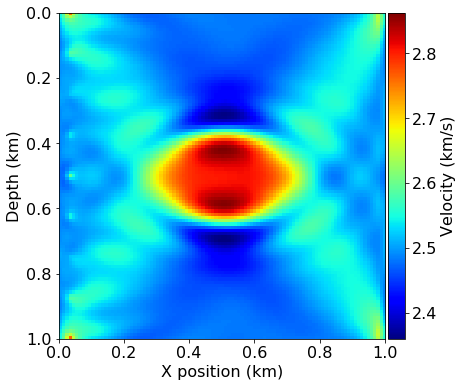

In [5]:
#NBVAL_SKIP

# Show what the update does to the model
from examples.seismic import plot_image, plot_velocity

model0.m.data[:] = result.x.astype(np.float32).reshape(model0.m.data.shape)
model0.vp = np.sqrt(1. / model0.m.data[40:-40, 40:-40])
plot_velocity(model0)

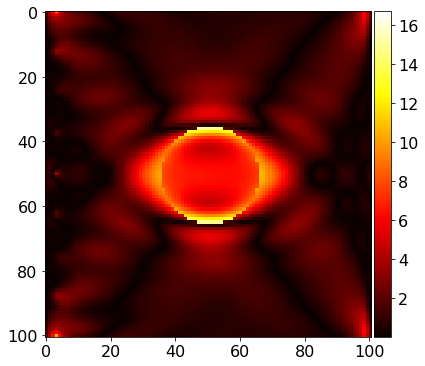

In [6]:
#NBVAL_SKIP

# Plot percentage error
plot_image(100*np.abs(model0.vp-get_true_model().vp.data)/get_true_model().vp.data, cmap="hot")

While we are resolving the circle at the centre of the domain there are also lots of artifacts throughout the domain.

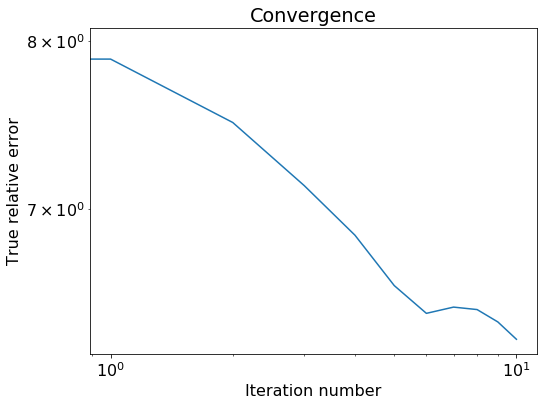

In [7]:
#NBVAL_SKIP
import matplotlib.pyplot as plt

# Plot objective function decrease
plt.figure()
plt.loglog(relative_error)
plt.xlabel('Iteration number')
plt.ylabel('True relative error')
plt.title('Convergence')
plt.show()

<sup>This notebook is part of the tutorial "Optimised Symbolic Finite Difference Computation with Devito" presented at the Intel® HPC Developer Conference 2017.</sup>